## Système de Recommandation de Contenus avec SARSA

### 🧠 Objectif du projet :
Construire un système de recommandation intelligent qui apprend à proposer les contenus les plus pertinents aux utilisateurs en analysant leurs interactions (clics, temps passé, etc.) sur une plateforme en ligne. Le système utilise l’algorithme SARSA (State-Action-Reward-State-Action) de Reinforcement Learning pour apprendre une politique de recommandation optimisée.



#### Labraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [2]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [3]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
52997,349,357,4.0,834751235,Four Weddings and a Funeral (1994),Comedy|Romance
79496,494,2028,5.0,1001666475,Saving Private Ryan (1998),Action|Drama|War
78802,489,3255,3.5,1385823957,"League of Their Own, A (1992)",Comedy|Drama
39679,274,2702,3.5,1171829688,Summer of Sam (1999),Drama
84765,549,1036,4.0,1464282638,Die Hard (1988),Action|Crime|Thriller
55992,369,59126,4.0,1237082441,Religulous (2008),Comedy|Documentary
23722,162,296,3.0,836488867,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
39892,274,4306,3.5,1171494063,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
63902,414,5291,4.0,1074004712,Rashomon (Rashômon) (1950),Crime|Drama|Mystery
19646,127,36517,4.0,1263527372,"Constant Gardener, The (2005)",Drama|Thriller


#### Filtrage des top utilisateurs et films

**=> Des milliers d’utilisateurs et de films.** 

**=> Beaucoup de données manquantes (certains utilisateurs notent très peu de films).**

**=> Un grand déséquilibre (quelques films populaires sont notés très souvent, d’autres très rarement).**

In [4]:
top_users = df['userId'].value_counts().head(20).index.tolist()
top_movies = df['movieId'].value_counts().head(50).index.tolist()
df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)]

#### # Réindexation


**=> userId pour les lignes de Q-Table**

**=> movieId pour les lignes de Q-Table**

**=> idx_to_movie lorsqu'on extrait argmax(Q["state"]) pour traduire l’index en vrai movieId**

In [5]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [6]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

#### Extraction de tous les genres possibles


In [7]:
genre_set = set()
for g in df['genres']:
    genre_set.update(g.split('|'))
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Encodage des genres pour chaque film


In [8]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [9]:
movie_genre_vectors = {mid: encoder_genres(genre_str) for mid, genre_str in movie_genres.items()}


#### Q-table


In [10]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [11]:
def choisir_action(user_idx):
    if np.random.rand() < epsilon:
        return np.random.randint(n_movies)
    else:    
        return np.argmax(q_table[user_idx])

#### Obtenir les genres préférés d’un utilisateur


In [12]:
def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array([movie_genre_vectors[mid] for mid in liked['movieId'] if mid in movie_genre_vectors])
    return vectors.mean(axis=0)

#### Récompense avec affinité de genre


In [13]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### Entraînement SARSA


In [14]:
clics_par_episode = []

for ep in tqdm(range(episodes), desc="Episodes"):
    user_idx = np.random.randint(n_users)
    action = choisir_action(user_idx)
    total_reward = 0

    for _ in range(max_steps):
        r = obtenir_recompense(user_idx, action)
        total_reward += r

        next_user_idx = np.random.randint(n_users)
        next_action = choisir_action(next_user_idx)

        cible = r + gamma * q_table[next_user_idx][next_action]
        q_table[user_idx][action] += alpha * (cible - q_table[user_idx][action])

        user_idx = next_user_idx
        action = next_action

    clics_par_episode.append(total_reward)



Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

Episodes: 100%|██████████| 500/500 [00:12<00:00, 41.01it/s]


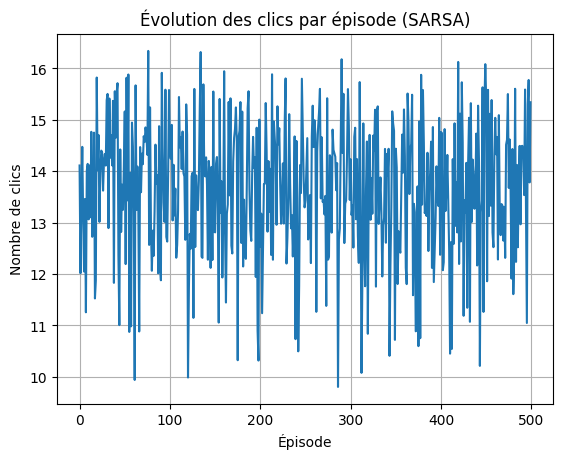

In [15]:
plt.plot(clics_par_episode)
plt.title("Évolution des clics par épisode (SARSA)")
plt.xlabel("Épisode")
plt.ylabel("Nombre de clics")
plt.grid()
plt.show()

In [16]:
recommandations = []

for user_id in user_to_idx:
    user_idx = user_to_idx[user_id]
    vus = set(df[df['userId'] == user_id]['movieId'])

    genres_aimes = []
    for _, row in df[(df['userId'] == user_id) & (df['rating'] >= 3.0)].iterrows():
        genres = movie_genres.get(row['movieId'], "")
        genres_aimes.extend(genres.split('|'))
    genres_aimes = set(genres_aimes)

    candidats = []
    for movie_idx in range(n_movies):
        movie_id = idx_to_movie[movie_idx]
        if movie_id in vus:
            continue
        genres_film = set(movie_genres.get(movie_id, "").split('|'))
        if not genres_aimes & genres_film:
            continue
        score = q_table[user_idx, movie_idx]
        candidats.append((movie_id, idx_to_title.get(movie_id, "Titre inconnu"), score))

    top_recos = sorted(candidats, key=lambda x: x[2], reverse=True)[:5]

    for reco in top_recos:
        recommandations.append({
            'userId': user_id,
            'movieId': reco[0],
            'title': reco[1],
            'score_Q': round(reco[2], 3)
        })

In [17]:
# Exporter les recommandations
df_reco = pd.DataFrame(recommandations)
df_reco.to_csv("recommandations_sarsa.csv", index=False)


In [18]:
df_reco1 = pd.read_csv("recommandations_sarsa.csv")

In [19]:
df_reco1.sample(20)

,userId,movieId,title,score_Q
60,606,380,True Lies (1994),1.411
6,182,595,Beauty and the Beast (1991),5.165
67,610,588,Aladdin (1992),1.071
36,380,150,Apollo 13 (1995),0.936
52,480,58559,"Dark Knight, The (2008)",0.596
39,380,590,Dances with Wolves (1990),0.000
5,177,589,Terminator 2: Judgment Day (1991),0.695
3,177,2762,"Sixth Sense, The (1999)",0.726
37,380,2858,American Beauty (1999),0.752
51,474,58559,"Dark Knight, The (2008)",0.000
